In [1]:
import qiskit
qiskit.__qiskit_version__

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


{'qiskit-terra': '0.22.2', 'qiskit-aer': '0.11.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.2', 'qiskit-nature': '0.5.0', 'qiskit-finance': '0.3.4', 'qiskit-optimization': '0.4.0', 'qiskit-machine-learning': '0.5.0'}

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as mplt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.quantum_info import Pauli
from qiskit.algorithms import NumPyEigensolver
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit.opflow import I, Z

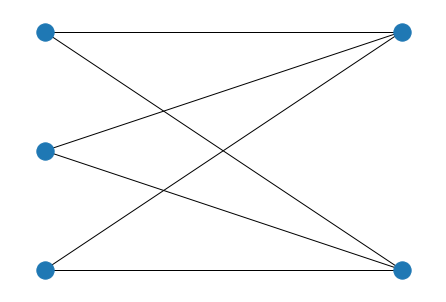

In [3]:
#The Graph we are going to cut
G=nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G,pos=nx.bipartite_layout(G,[0,1,2]))

In [4]:
#to add ZZ term to each edge
def append_zz_term(qc,q1,q2,gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma,q2)
    qc.cx(q1,q2)

In [5]:
#create cost function circuit
def cost_circuit(G, gamma):
   N = G.number_of_nodes()
   qc = QuantumCircuit(N,N);
   for i,j in G.edges():
        append_zz_term(qc,i,j,gamma)
        qc.barrier()
   return qc

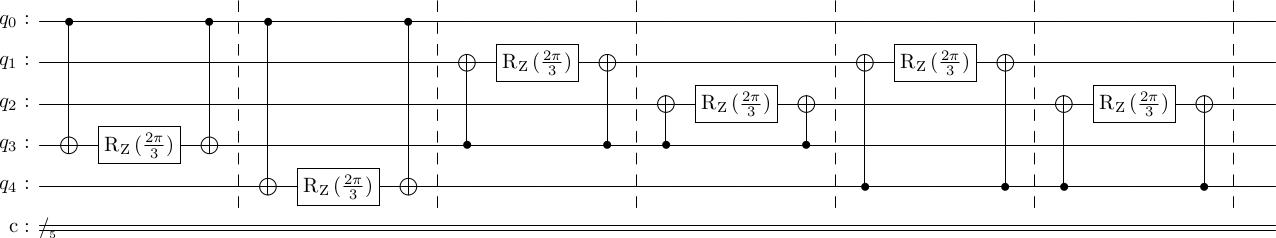

In [6]:
qc = cost_circuit(G,np.pi/3 )
qc.draw('latex')

In [7]:
#building mixer circuit appending x term 
def append_x_term(qc, q1, beta):
    qc.rx(2*beta,q1)

In [8]:
#mixer circuit append applied to each node
def mixer_circuit(G, beta):
    N=G.number_of_nodes()
    qc=QuantumCircuit(N,N)
    for i in G.nodes:
        append_x_term(qc,i,beta)
    return qc

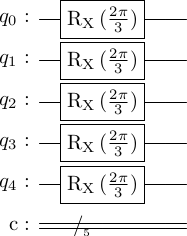

In [9]:
qc=mixer_circuit(G, np.pi/3)
qc.draw('latex')

In [10]:
def qaoa_circuit(G, beta, gamma):
    assert(len(beta)==len(gamma))
    p=len(beta)
    N = G.number_of_nodes()
    new_qc=QuantumCircuit(N,N)
    #Hadamard on all qubits to put them into superposition
    new_qc.h(range(N))
    #apply the cost and mixer operator p times
    for i in range(p):
        #qc+=cost_circuit(G,gamma[i])
        #cc1=cost_circuit(G,gamma[i])
        new_qc=new_qc.compose(cost_circuit(G,gamma[i]))
        #qc+=mixer_circuit(G,beta[i])
        new_qc=new_qc.compose(mixer_circuit(G,beta[i]))
        #qc.barrier()
    new_qc.barrier(range(N))
    new_qc.measure(range(N),range(N))
    return new_qc

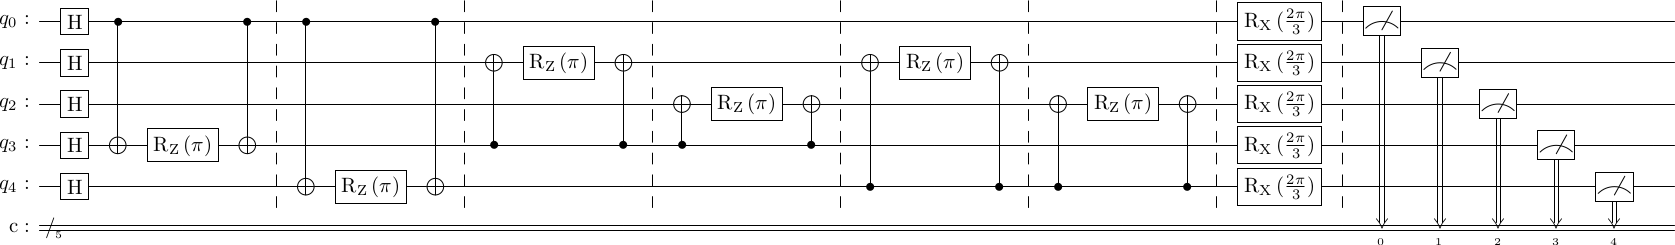

In [11]:
qc = qaoa_circuit(G,[np.pi/3],[np.pi/2])
qc.draw('latex')

In [12]:
def invert_counts(counts):
    return {k[::-1]:v for k,v in counts.items()}

In [13]:
backend = Aer.get_backend('qasm_simulator')
job= execute(qc,backend)
result=job.result()
print(invert_counts(result.get_counts()))

{'10110': 27, '01111': 30, '10010': 30, '01011': 30, '10001': 30, '10100': 21, '00001': 36, '01110': 38, '11000': 45, '11100': 27, '10101': 41, '00111': 36, '01001': 28, '10111': 44, '00100': 30, '11011': 30, '11111': 29, '00011': 32, '10011': 28, '00000': 25, '01000': 34, '10000': 36, '01100': 31, '00110': 39, '00010': 28, '01101': 21, '11001': 31, '11110': 35, '11010': 29, '11101': 38, '00101': 31, '01010': 34}


In [14]:
def maxcut_obj(bitstring, G):
    cut=0
    for i,j in G.edges():
        if bitstring[i]!=bitstring[j]:
            cut+=-1
    return cut

maxcut_obj('11100',G)

-6

In [15]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-3.001953125

In [16]:
#classical optimizer
def create_black_box_obj(G,p):
    backend=Aer.get_backend('qasm_simulator')
    def f(theta):
        beta = theta[:p]
        gamma = theta[p:]
        qc = qaoa_circuit(G, beta, gamma)
        counts = execute(qc, backend,seed_simulator=13).result().get_counts()
        return compute_maxcut_energy(invert_counts(counts),G)
    return f

In [17]:
# p is the number of QAOA alternating operators
p = 5
obj = create_black_box_obj(G, p)
#The point was hand-picked such that the optimization with full statevector energy evaluation 
#would converge arbitrarily close to true optimum (-6). This was done to highlight the difference in optimizer performance
#between sample-based and full statevector energy evaluation
#In general, it is not possible to produce initial points with such guarantee
init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':10000, 'disp': True})
res_sample


   Normal return from subroutine COBYLA



     fun: -5.7333984375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 149
  status: 1
 success: True
       x: array([1.94143498, 2.1299158 , 2.00399103, 1.93617518, 0.39549954,
       2.02019668, 6.25231343, 2.27631041, 3.71008281, 5.79211129])

   NFVALS =  149   F =-5.733398E+00    MAXCV = 0.000000E+00
   X = 1.941435E+00   2.129916E+00   2.003991E+00   1.936175E+00   3.954995E-01
       2.020197E+00   6.252313E+00   2.276310E+00   3.710083E+00   5.792111E+00


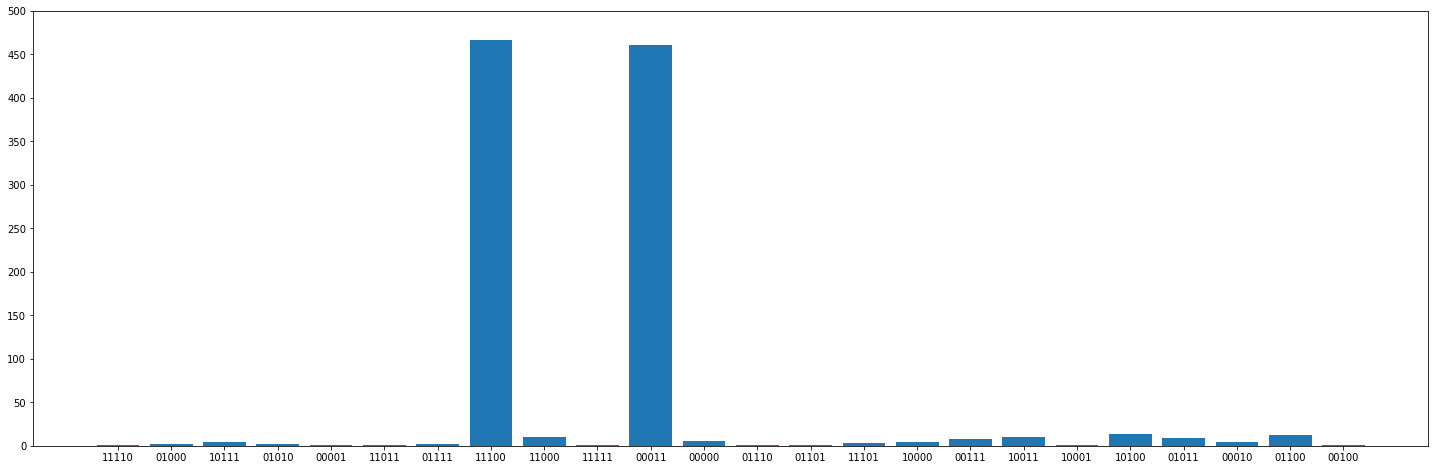

{'11110': 1,
 '01000': 2,
 '10111': 4,
 '01010': 2,
 '00001': 1,
 '11011': 1,
 '01111': 2,
 '11100': 467,
 '11000': 10,
 '11111': 1,
 '00011': 461,
 '00000': 5,
 '01110': 1,
 '01101': 1,
 '11101': 3,
 '10000': 4,
 '00111': 8,
 '10011': 10,
 '10001': 1,
 '10100': 13,
 '01011': 9,
 '00010': 4,
 '01100': 12,
 '00100': 1}

In [18]:
optimal_theta = res_sample['x']
qc = qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())


bitstrings = list(counts.keys())
values = list(counts.values())
#plotting
mplt.figure(figsize=(25, 8))
mplt.bar(range(len(bitstrings)), values, tick_label=bitstrings)
mplt.yticks(np.arange(0, 550, 50.0))
mplt.show()
counts

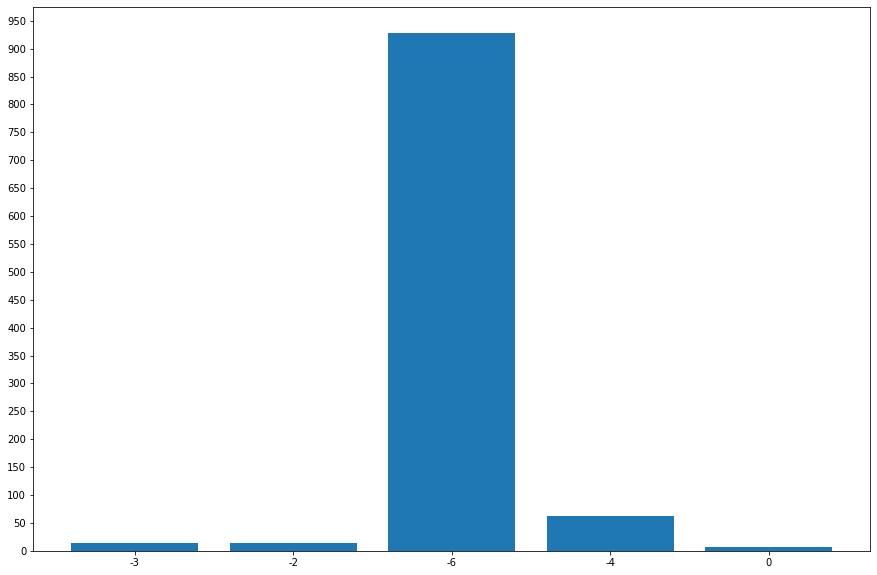

defaultdict(int, {-3: 14, -2: 14, -6: 928, -4: 62, 0: 6})

In [19]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G)] += v

#x,y = zip(*energies.items())
#mplt.bar(x,y)
#mplt.figure(figsize=(25, 10))
#mplt.bar(range(len(energies)), energies.values(), tick_label=energies.keys())
#mplt.show()
keys = list(energies.keys())
values = list(energies.values())
#plotting
mplt.figure(figsize=(15, 10))
#mplt.yticks(values * 50, ['%d' % val for val in values])
mplt.bar(range(len(keys)), values, tick_label=keys)
#mplt.xticks(np.arange(-6,0,2.0))
mplt.yticks(np.arange(0, max(values)+50, 50.0))

mplt.show()
energies

In [20]:
#BUILDING HAMILTONIAN in Qiskit

0.5 * IIIZZ
+ 0.5 * IIZIZ
+ 0.5 * IZIZI
+ 0.5 * IZZII
+ 0.5 * ZIIZI
+ 0.5 * ZIZII


/tmp/ipykernel_97/2757306837.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  linear=nx.adjacency_matrix(G).dot(np.ones(n_qubits)),
/tmp/ipykernel_97/2757306837.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  quadratic=-nx.adjacency_matrix(G),
